D Siva Manoj | MDS202216 | assignment_2 | part 2

In [1]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.metrics")

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix,vstack


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, fbeta_score, make_scorer
from sklearn.metrics import precision_recall_curve, auc

import pandas as pd
import mlflow
from functools import partial

#### loading the dataset

In [2]:
# the train test and validation data are taken from part 1.

train = pd.read_csv(r"C:\Users\win\Desktop\Data_Science\4th_sem\Applied_ML\assignment_02\train.csv")
test = pd.read_csv(r"C:\Users\win\Desktop\Data_Science\4th_sem\Applied_ML\assignment_02\test.csv")
val = pd.read_csv(r"C:\Users\win\Desktop\Data_Science\4th_sem\Applied_ML\assignment_02\validation.csv")


In [3]:
# Adding new feature as number of words
train["no_of_words"] = train['text'].apply(lambda x: len(x.split()))
test["no_of_words"] = test['text'].apply(lambda x: len(x.split()))
val["no_of_words"] = val['text'].apply(lambda x: len(x.split()))

In [4]:
# seperating the Features and target variable
X_train, y_train = train.drop("spam", axis = 1), train["spam"]
X_val, y_val = val.drop("spam", axis = 1), val["spam"]
X_test, y_test = test.drop("spam", axis = 1), test["spam"]

In [5]:
# Function for tf idf vectorization
def df_after_vectorization(X_train,X,no_of_words):
    vectorizer = TfidfVectorizer()
    X_train = vectorizer.fit_transform(X_train["text"])
    X = vectorizer.transform(X['text'])
    no_of_words_column = csr_matrix(no_of_words['no_of_words'].values.reshape(-1, 1))
    # Horizontally stack the sparse matrices
    X_combined = hstack([X, no_of_words_column])
    return X_combined

In [6]:
# Converting the data into numerical features using tf idf vectorization
vectorizer = TfidfVectorizer()
X_val = df_after_vectorization(X_train,X_val,val)
X_test = df_after_vectorization(X_train,X_test,test)
X_train = vectorizer.fit_transform(X_train["text"])
no_of_words_column = csr_matrix(train['no_of_words'].values.reshape(-1,1))
X_train = hstack([X_train,no_of_words_column])

In [7]:
# Function to display confusion matrix
def display_confusion_matrix(y_actual, y_pred, model_name, run_id):
    target_labels = ["Not Spam", "Spam"]
    cm = confusion_matrix(y_actual, y_pred)
    display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = target_labels)
    fig, ax = plt.subplots(figsize = (5, 3))
    display_cm.plot(ax = ax, cmap = "Blues")
    
    # Save confusion matrix as artifact in MLflow
    plt.savefig(f"confusion_matrix_{model_name}.png")

    # uploading the above saved figure into artifacts
    mlflow.log_artifact(f"confusion_matrix_{model_name}.png", run_id=run_id)

    plt.show()
    plt.close()

# Function to display precision-recall curve
def display_precision_recall_curve(y_actual, y_pred, model_name, run_id):
    # Calculate precision and recall
    precision, recall, _ = precision_recall_curve(y_actual, y_pred)
    
    # Plot precision-recall curve
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.grid(True)
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.fill_between(recall, precision, alpha=0.2, color='b')
    
    # Save precision-recall curve as artifact in MLflow
    plt.savefig(f"precision_recall_curve_{model_name}.png")

    # uploading the above saved figure into artifacts
    mlflow.log_artifact(f"precision_recall_curve_{model_name}.png", run_id=run_id)

    plt.show()
    plt.close()

#### Reading the data frame from csv file


In [8]:
# beta less than 1 indicates giving more priority to precision compared to recall.
beta = 0.8  
scorer = make_scorer(fbeta_score, beta=beta)
X_train_val = vstack([X_train,X_val])
y_train_val = pd.concat([y_train,y_val])

In [9]:

def model_runs(model_name,param_grid,model_classifier):

    # Create the GridSearchCV object with 5-fold cross-validation
    grid_search = GridSearchCV(estimator=model_classifier, param_grid=param_grid, cv=5, scoring=scorer)

    mlflow.set_tracking_uri("http://127.0.0.1:5000")
    # Start MLflow run
    
    with mlflow.start_run(run_name=model_name) as run:

        # Fit the model to the training data with cross-validation
        grid_search.fit(X_train_val, y_train_val)
        
        # Log parameters and metrics to MLflow
        mlflow.log_params(grid_search.best_params_)
        mlflow.log_metric("best_fbeta_score_train", grid_search.best_score_)
        
        # Retrieve the best model
        best_model = grid_search.best_estimator_
        
        # Log the best model to MLflow
        mlflow.sklearn.log_model(best_model, "best_"+model_name)
        
        # Make predictions on the test set using the best model
        y_pred = best_model.predict(X_test)
        
        # Evaluate the model on the test set
        fbeta_Score = fbeta_score(y_test, y_pred, beta=beta)
        
        # Log the evaluation metric to MLflow
        mlflow.log_metric("fbeta_score_on_test", fbeta_Score)

        precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
        auc_pr = auc(recall, precision)
        recall_value = recall_score(y_test, y_pred)
        precision_value = precision_score(y_test, y_pred)
        
        # Log the additional metrics to MLflow
        mlflow.log_metric("auc_pr", auc_pr)
        mlflow.log_metric("recall", recall_value)
        mlflow.log_metric("precision", precision_value)

        print(f"Training {model_name} Classifer :")
        print(f"f beta score on cross validation data is {grid_search.best_score_}")
        print(f"f beta score on cross test data is {fbeta_Score}")
        print(f"AUC of Precision Recall Curve is {auc_pr}")
        
        print("\n\nConfusion Matrix")
        display_confusion_matrix(y_test, y_pred, model_name, run.info.run_id)
        

        print("\n\nPrecision Recall Curve")
        # Display and log precision-recall curve
        display_precision_recall_curve(y_test, y_pred, model_name, run.info.run_id)

        
        

In [10]:
param_grid_dt = {
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 5, 7, 9],
        'min_samples_split': [2, 5, 10],
        'class_weight': [None, 'balanced']
    }


param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2']
}


param_grid_rf = {
    'n_estimators': [200, 300],
    'max_depth': [5,7,None],
    'class_weight' : [None,'balanced']
}

#### 1) Logistic Regression

Training Logistic Regression Classifer :
f beta score on cross validation data is 0.9808586387545022
f beta score on cross test data is 0.9931604445711029
AUC of Precision Recall Curve is 0.9935097123269256


Confusion Matrix


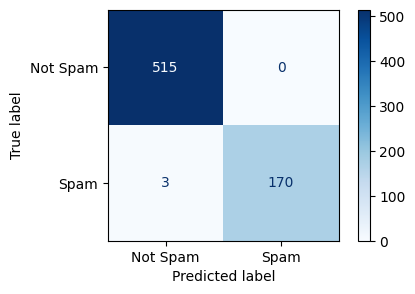



Precision Recall Curve


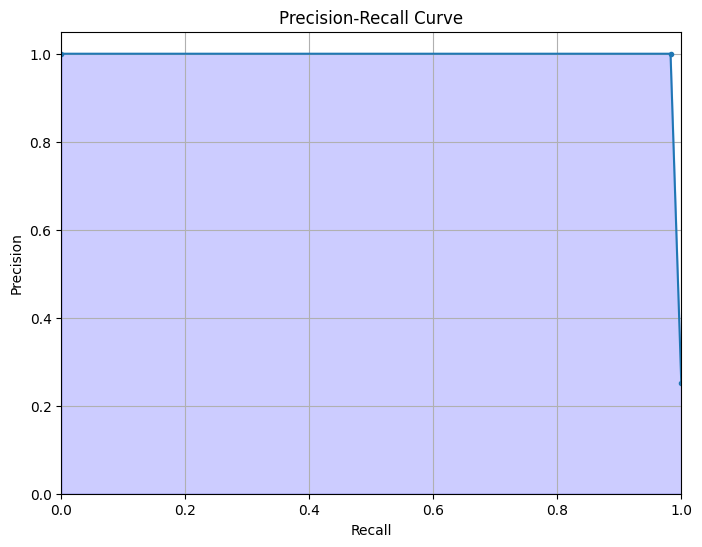

In [11]:
model_runs("Logistic Regression", param_grid_lr, LogisticRegression(random_state=42))

#### 2) Decision Trees

Training Decision Tree Classifer :
f beta score on cross validation data is 0.9222245147061601
f beta score on cross test data is 0.9172128811627244
AUC of Precision Recall Curve is 0.9271498382926232


Confusion Matrix


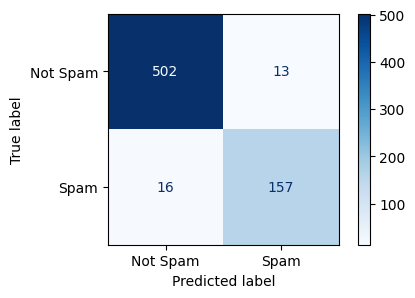



Precision Recall Curve


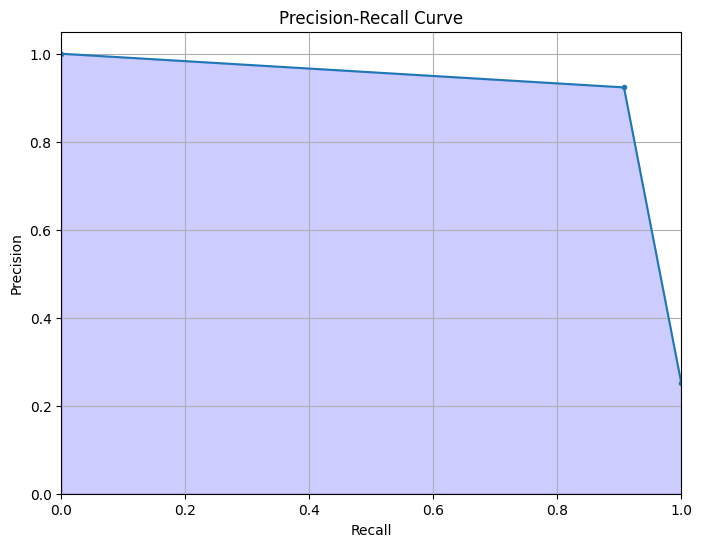

In [12]:
model_runs("Decision Tree", param_grid_dt, DecisionTreeClassifier(random_state=42))


#### 3) Random Forest

Training Random Forest Classifer :
f beta score on cross validation data is 0.9624597641324113
f beta score on cross test data is 0.9632092198581561
AUC of Precision Recall Curve is 0.9665869908589865


Confusion Matrix


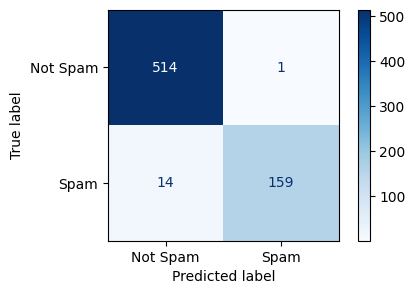



Precision Recall Curve


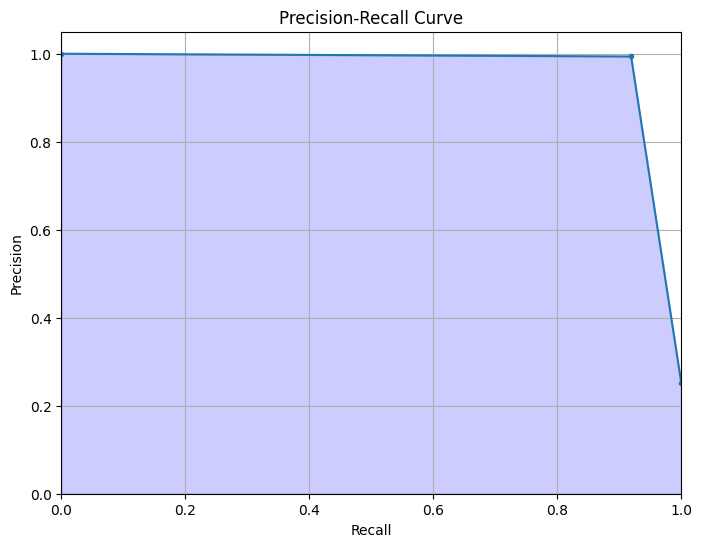

In [13]:
model_runs("Random Forest", param_grid_rf, RandomForestClassifier(random_state=42))
